# Intro
This notebook tests different kinds of smoothing

In [1]:
# General stuff
import logging
import sys
from pathlib import Path
import matplotlib.pyplot as plt

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
    format="%(asctime)s.%(msecs)03d | %(levelname)-8s | %(funcName)s - %(filename)s:%(lineno)d : %(message)s",
                   )
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("PIL").setLevel(logging.WARNING)
plt.style.use(["paper", "kraken"])

In [46]:
from zhunter.smoothing import *
from zhunter.misc import generate_fake_1D_spectrum, generate_fake_2D_spectrum
from zhunter.spectral_functions import extract_1d_from_2d
import zhunter.io as io

In [3]:
wvlg, flux, unc = generate_fake_1D_spectrum(
    SNR=1,
    spec_start=650,
    spec_end=663,
    N_spec=3000,
    emission_line=True,
)

2024-02-22 05:36:55,181.181 | DEBUG    | generate_fake_1D_spectrum - misc.py:87 : Adding an emission line with mean: 656.28, stddev: 1, amplitude: 4


In [4]:
names = ["Gaussian", "iSpec", "SpectRes", "Rolling mean", "ChatGPT"]
funcs = [convolve_gaussian, convolve_ispec, rebin_spectres_1d, rolling_mean, rebin_spectrum_1d]
args = [5,5000,10,10,10]
smoothings = {}
for i in range(5):
    smoothings[names[i]] = {}
    _wvlg, _flux, _unc = funcs[i](wvlg.value, flux.value, unc.value, args[i])
    smoothings[names[i]]['wvlg'] = _wvlg
    smoothings[names[i]]['flux'] = _flux
    smoothings[names[i]]['unc'] = _unc

2024-02-22 05:36:55,191.191 | DEBUG    | convolve_gaussian - smoothing.py:73 : Performing Gaussian convolution
2024-02-22 05:36:55,193.193 | WARNING  | convolve_gaussian - smoothing.py:77 : Error/uncertainty propagation is not implemented for convolution.
2024-02-22 05:36:55,194.194 | INFO     | convolve_ispec - smoothing.py:197 : Convolving using iSpec
2024-02-22 05:36:55,289.289 | INFO     | convolve_ispec - smoothing.py:280 : Spectra convolved!
2024-02-22 05:36:55,289.289 | DEBUG    | rebin_spectres_1d - smoothing.py:88 : Rebinning 1D spectrum using SpectRes
2024-02-22 05:36:55,303.303 | INFO     | rebin_spectrum_1d - smoothing.py:315 : Simple rebinning.


# Display

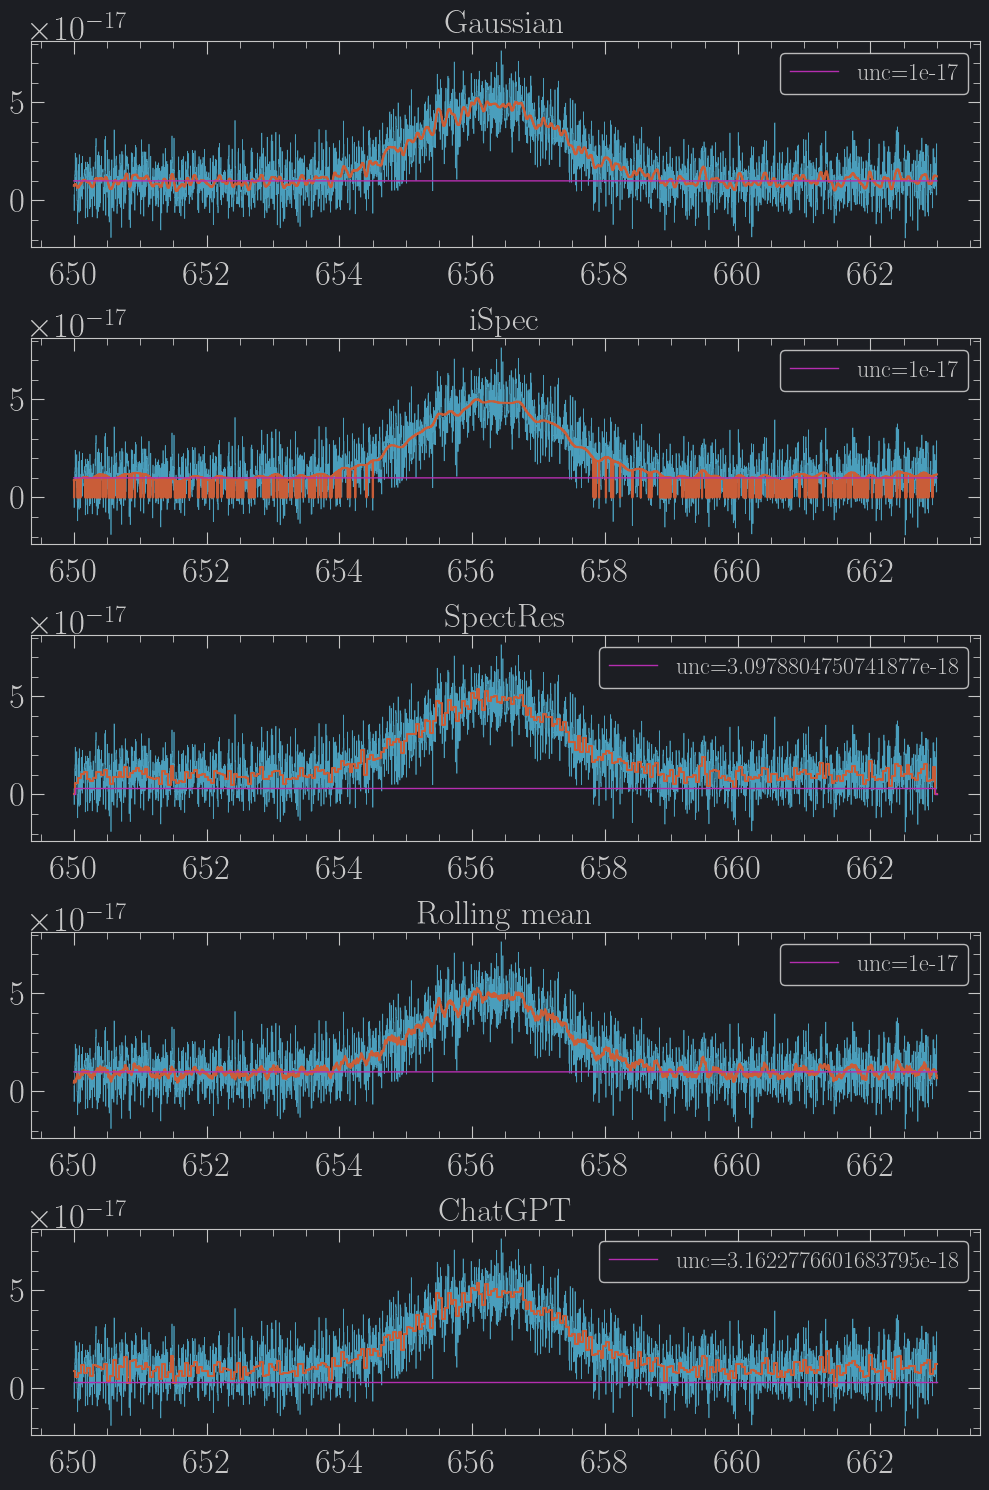

In [5]:
fig, axes = plt.subplots(len(smoothings), figsize=(10,15), tight_layout=True)
for ax, sm in zip(axes, smoothings.items()):
    n, s = sm
    ax.plot(wvlg, flux, drawstyle='steps-mid', lw=0.5)
    ax.plot(s["wvlg"], s["flux"], drawstyle='steps-mid', lw=1.5)
    ax.plot(s["wvlg"], s["unc"], drawstyle='steps-mid', lw=1, label=f'unc={np.median(s["unc"])}')
    ax.legend()
    ax.set_title(n)

plt.show()

# 2D spectrum

## Fake spectrum

In [6]:
wvlg, spat, flux, unc = generate_fake_2D_spectrum(
    SNR=1,
    spec_start=650,
    spat_start=1,
    N_spec=500,
    spec_pix_scale=0.02,
    emission_line=True,
    nodding=True,
)

## Real spectrum

In [50]:
fname = '/Users/palmerio/Code_projects/xsh-quickred/VIS/Output/xsh_scired_slit_nod_SCI_SLIT_FLUX_MERGE2D_VIS_VIS_1x2_100k.fits'
wvlg, spat, flux, unc, hdr = io.read_fits_2D_spectrum(fname)


2024-02-22 05:55:11,192.192 | INFO     | read_fits_2D_spectrum - io.py:292 : Attempting to read file:
/Users/palmerio/Code_projects/xsh-quickred/VIS/Output/xsh_scired_slit_nod_SCI_SLIT_FLUX_MERGE2D_VIS_VIS_1x2_100k.fits
2024-02-22 05:55:11,231.231 | WARNING  | _showwarning - logger.py:237 : UnitsWarning: 'erg/s/cm2/Angstrom' contains multiple slashes, which is discouraged by the FITS standard
2024-02-22 05:55:11,312.312 | DEBUG    | get_constructor - io.py:720 : Using the FITS CD matrix.
2024-02-22 05:55:11,312.312 | DEBUG    | get_constructor - io.py:735 : PIX=1.0 VAL=-10.4200000762939 DELT=0.159999847412109
2024-02-22 05:55:11,313.313 | DEBUG    | get_wavelength_constructor - io.py:760 : Using the FITS CD matrix.
2024-02-22 05:55:11,314.314 | DEBUG    | get_wavelength_constructor - io.py:775 : PIX=1.0 VAL=533.66 DELT=0.0199999999999818


## Show full 2D spectrum

In [51]:
from astropy.visualization import ZScaleInterval, imshow_norm
import astropy.units as u
import astropalmerio.spectra as sp

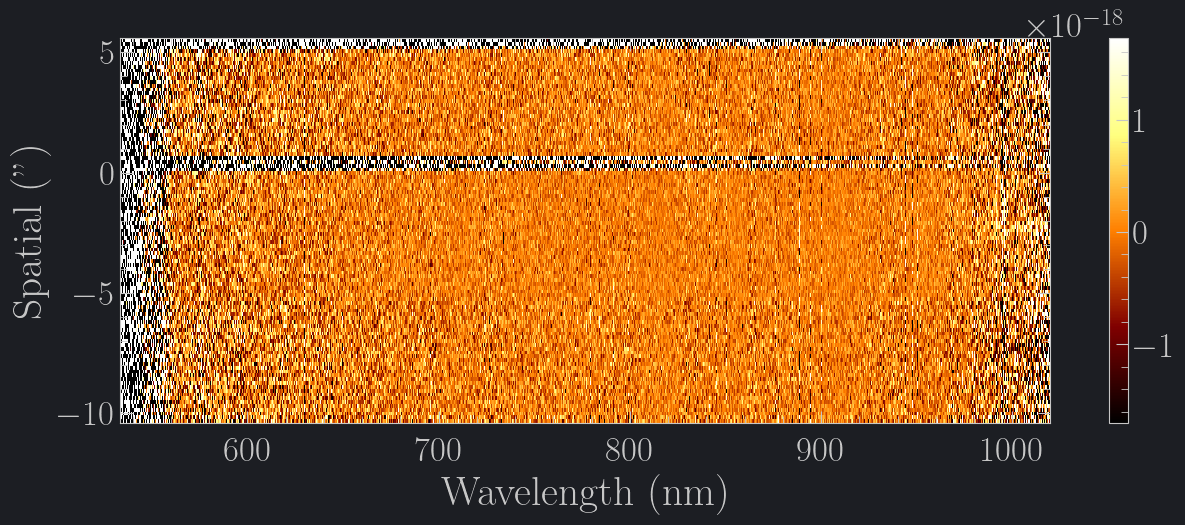

In [87]:

fig, ax = plt.subplots(figsize=(15,5))
# Plot 2D
im, norm = imshow_norm(flux.value, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       extent=[
                           wvlg[0].value,
                           wvlg[-1].value,
                           spat[0].value,
                           spat[-1].value,
                       ],
                       cmap='afmhot',
                       interpolation='none',
                      )

plt.colorbar(im)
ax = plt.gca()
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial (")')

plt.show()

## Show rebinned 2D spectrum

In [107]:
spectral_rebin_factor = 100
spatial_rebin_factor = 1

In [108]:
wvlg_rebin, spat_rebin, flux_rebin, unc_rebin = rebin_spectrum_2d(
    wvlg,
    spat,
    flux,
    unc=unc,
    binning_factors=(spatial_rebin_factor, spectral_rebin_factor),
)

In [109]:
wvlg_rebin_sp, spat_rebin_sp, flux_rebin_sp, unc_rebin_sp = rebin_spectres_2d(
    wvlg.value,
    spat.value,
    flux.value,
    unc=unc.value,
    smoothing=(spatial_rebin_factor, spectral_rebin_factor),
)

2024-02-22 08:46:02,050.050 | DEBUG    | rebin_spectres_2d - smoothing.py:120 : Rebinning 2D spectrum using SpectRes


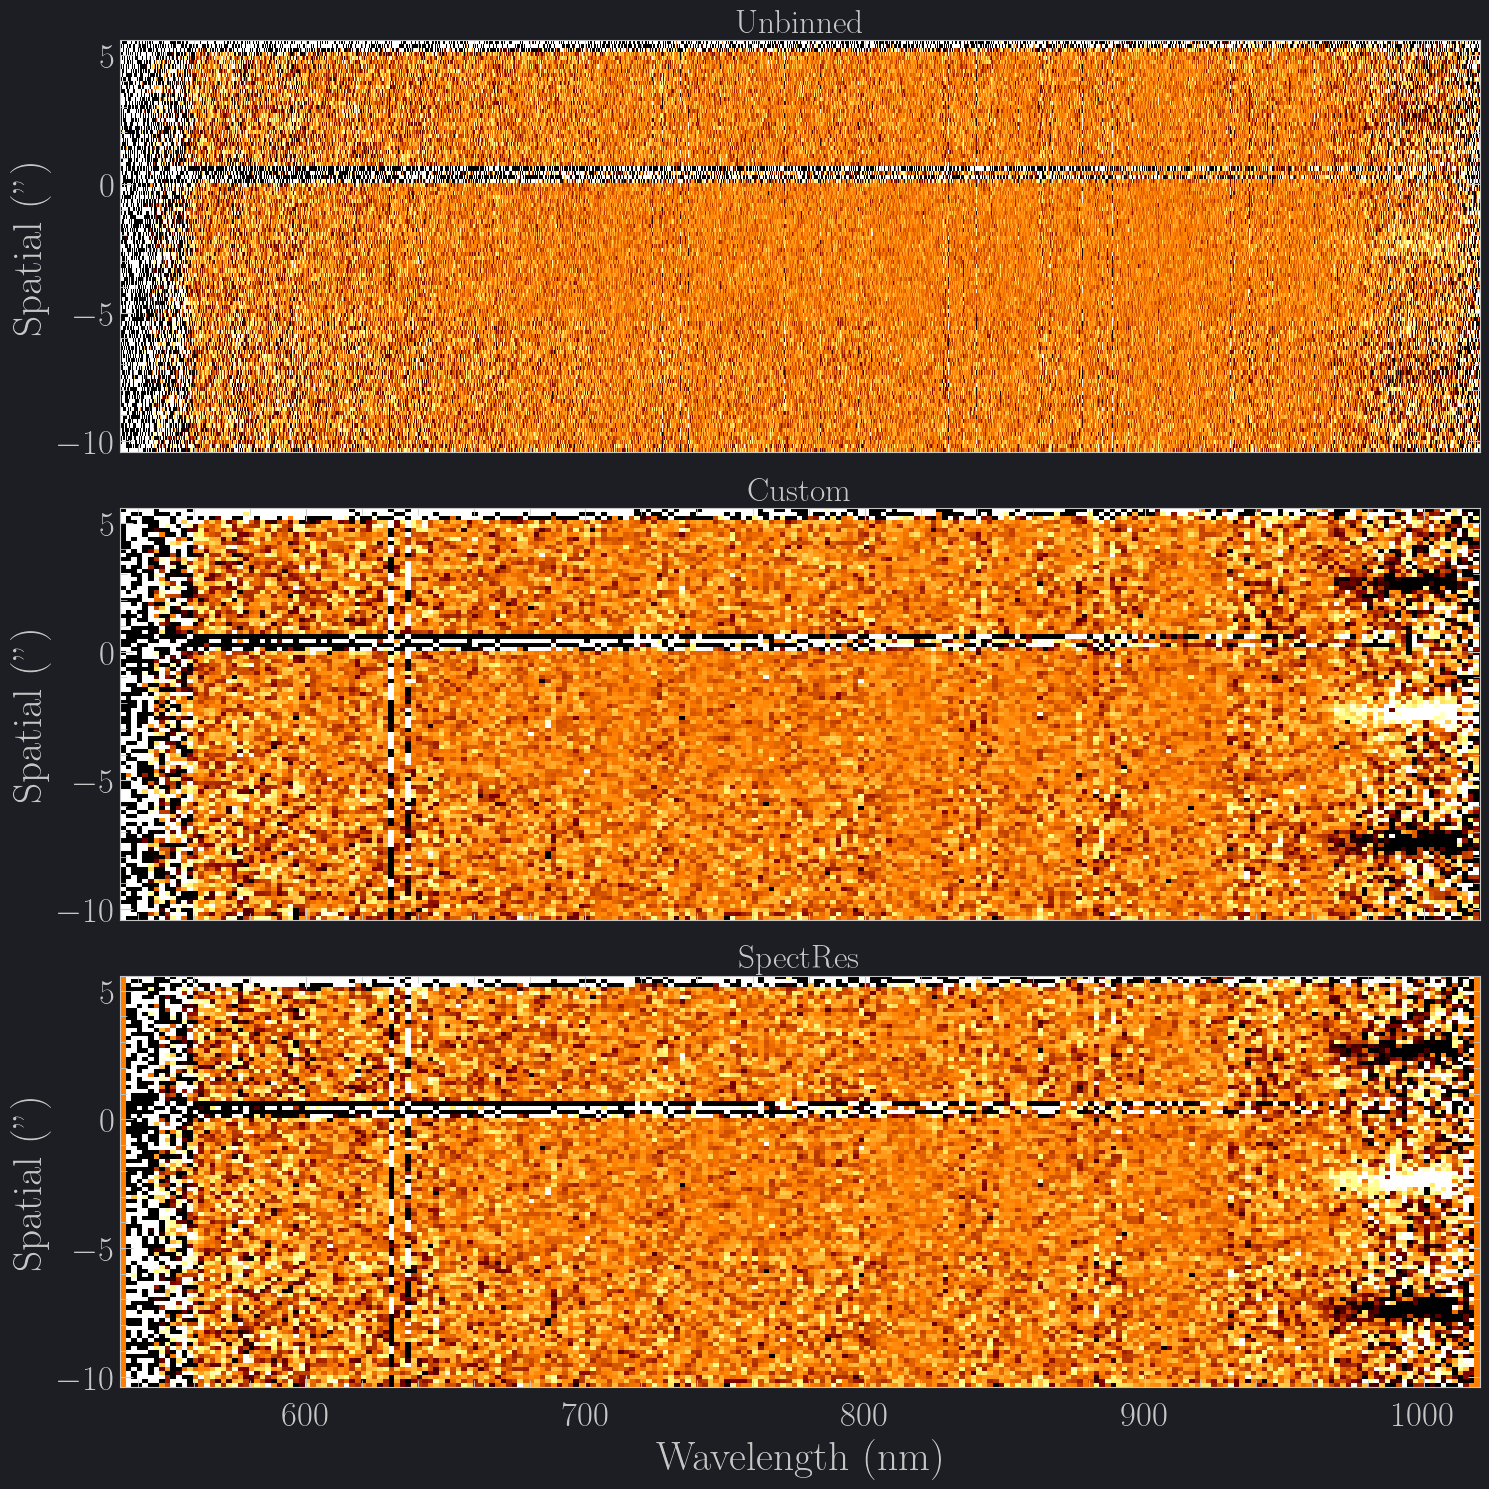

In [120]:
fig, axes = plt.subplots(3,1, figsize=(15,15), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.set_title('Unbinned')
# Plot 2D
im, _ = imshow_norm(flux.value, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       extent=[
                           wvlg[0].value,
                           wvlg[-1].value,
                           spat[0].value,
                           spat[-1].value,
                       ],
                       cmap='afmhot',
                       interpolation='none',
#                        vmin=norm.vmin,
#                        vmax=norm.vmax,
                      )
# plt.colorbar(im)
ax.set_ylabel('Spatial (")')

ax = axes[1]
ax.set_title('Custom')
# Plot 2D
im, _ = imshow_norm(flux_rebin.value, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       extent=[
                           wvlg_rebin[0].value,
                           wvlg_rebin[-1].value,
                           spat_rebin[0].value,
                           spat_rebin[-1].value,
                       ],
                       cmap='afmhot',
                       interpolation='none',
#                        vmin=norm.vmin,
#                        vmax=norm.vmax,
                      )
ax.set_ylabel('Spatial (")')

ax = axes[2]
ax.set_title('SpectRes')
# Plot 2D
im, _ = imshow_norm(flux_rebin_sp, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       extent=[
                           wvlg_rebin_sp[0],
                           wvlg_rebin_sp[-1],
                           spat_rebin_sp[0],
                           spat_rebin_sp[-1],
                       ],
                       cmap='afmhot',
                       interpolation='none',
#                        vmin=norm.vmin,
#                        vmax=norm.vmax,
                      )


ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial (")')
# fig.subplots_adjust(hspace=0)


plt.show()

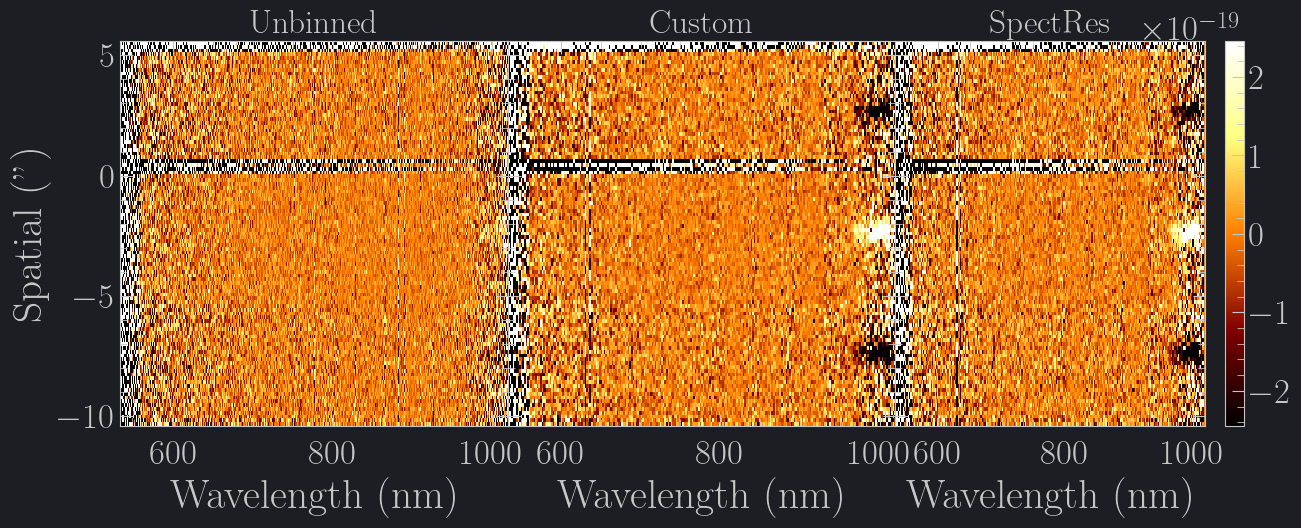

In [118]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)

ax = axes[0]
ax.set_title('Unbinned')
# Plot 2D
im, _ = imshow_norm(flux.value, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       extent=[
                           wvlg[0].value,
                           wvlg[-1].value,
                           spat[0].value,
                           spat[-1].value,
                       ],
                       cmap='afmhot',
                       interpolation='none',
                       vmin=norm.vmin,
                       vmax=norm.vmax,
                      )
ax.set_ylabel('Spatial (")')
ax.set_xlabel('Wavelength (nm)')

ax = axes[1]
ax.set_title('Custom')
# Plot 2D
im, _ = imshow_norm(flux_rebin.value, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       extent=[
                           wvlg_rebin[0].value,
                           wvlg_rebin[-1].value,
                           spat_rebin[0].value,
                           spat_rebin[-1].value,
                       ],
                       cmap='afmhot',
                       interpolation='none',
#                        vmin=norm.vmin,
#                        vmax=norm.vmax,
                      )
ax.set_xlabel('Wavelength (nm)')

ax = axes[2]
ax.set_title('SpectRes')
# Plot 2D
im, _ = imshow_norm(flux_rebin_sp, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       extent=[
                           wvlg_rebin_sp[0],
                           wvlg_rebin_sp[-1],
                           spat_rebin_sp[0],
                           spat_rebin_sp[-1],
                       ],
                       cmap='afmhot',
                       interpolation='none',
#                        vmin=norm.vmin,
#                        vmax=norm.vmax,
                      )


ax.set_xlabel('Wavelength (nm)')
fig.subplots_adjust(wspace=0)
plt.colorbar(im)


plt.show()

## Compare extraction methods

In [112]:
# extract center +/- 10 %
n_spat = len(spat)
spat_extr_bounds = (spat[int(np.ceil(0.4*n_spat))],spat[int(np.ceil(0.6*n_spat))]) 

### First rebinning 2D, then extracting 1D

In [113]:
wvlg_rebin, spat_rebin, flux_rebin, unc_rebin = rebin_spectrum_2d(
    wvlg,
    spat,
    flux,
    unc=unc,
    binning_factors=(spatial_rebin_factor, spectral_rebin_factor),
)
flux_rebin_first, unc_rebin_first = extract_1d_from_2d(
    spat_rebin,
    flux_rebin,
#     spat_bounds=(-1.8*u.arcsec, -3.2*u.arcsec),
    spat_bounds=spat_extr_bounds,
    unc=unc_rebin,
)

2024-02-22 09:09:39,739.739 | DEBUG    | extract_1d_from_2d - spectral_functions.py:19 : Extracting from -3.860 arcsec to -0.660 arcsec corresponding to 40 to 60 pixels.


In [114]:
wvlg_rebin_sp, spat_rebin_sp, flux_rebin_sp, unc_rebin_sp = rebin_spectres_2d(
    wvlg.value,
    spat.value,
    flux.value,
    unc=unc.value,
    smoothing=(spatial_rebin_factor, spectral_rebin_factor),
)
flux_rebin_sp_first, unc_rebin_sp_first = extract_1d_from_2d(
    spat_rebin_sp*u.arcsec,
    flux_rebin_sp,
#     spat_bounds=(-1.8*u.arcsec, -3.2*u.arcsec),
    spat_bounds=spat_extr_bounds,
    unc=unc_rebin_sp,
)

2024-02-22 09:09:39,886.886 | DEBUG    | rebin_spectres_2d - smoothing.py:120 : Rebinning 2D spectrum using SpectRes
2024-02-22 09:09:41,914.914 | DEBUG    | extract_1d_from_2d - spectral_functions.py:19 : Extracting from -3.860 arcsec to -0.660 arcsec corresponding to 40 to 60 pixels.


### First extracting from 2D, then rebinning 1D

In [115]:

flux_extr, unc_extr = extract_1d_from_2d(
    spat,
    flux,
#     spat_bounds=(-1.8*u.arcsec, -3.2*u.arcsec),
    spat_bounds=spat_extr_bounds,
    unc=unc,
)
wvlg_extr_first, flux_extr_first, unc_extr_first = rebin_spectres_1d(
    wvlg.value,
    flux_extr,
    unc_extr,
    smoothing=spectral_rebin_factor,
)


2024-02-22 09:09:41,921.921 | DEBUG    | extract_1d_from_2d - spectral_functions.py:19 : Extracting from -3.860 arcsec to -0.660 arcsec corresponding to 40 to 60 pixels.
2024-02-22 09:09:41,924.924 | DEBUG    | rebin_spectres_1d - smoothing.py:88 : Rebinning 1D spectrum using SpectRes


### Plot the extractions

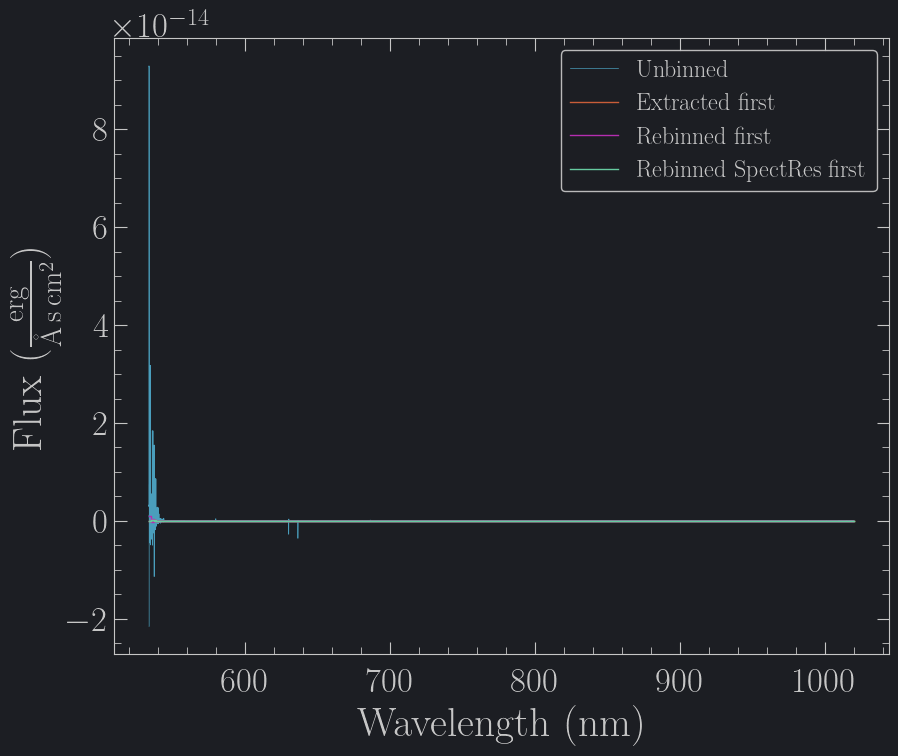

In [116]:
fig, ax = plt.subplots(figsize=(10,8))

# Unbinned
art, = ax.plot(wvlg, flux_extr, drawstyle='steps-mid', lw=0.5, label='Unbinned')
ax.plot(wvlg, unc_extr, drawstyle='steps-mid', lw=1, color=art.get_color())

# Extracted 1D before rebinning 1D
art, = ax.plot(wvlg_extr_first, flux_extr_first, drawstyle='steps-mid', lw=1, label='Extracted first')
ax.plot(wvlg_extr_first, unc_extr_first, drawstyle='steps-mid', lw=1, color=art.get_color())

# Rebinned 2D before extracting 1D
art, = ax.plot(wvlg_rebin, flux_rebin_first, drawstyle='steps-mid', lw=1, label="Rebinned first")
ax.plot(wvlg_rebin, unc_rebin_first, drawstyle='steps-mid', lw=1, color=art.get_color())


# Rebinned 2D before extracting 1D
art, = ax.plot(wvlg_rebin_sp, spatial_rebin_factor*flux_rebin_sp_first, drawstyle='steps-mid', lw=1, label="Rebinned SpectRes first")
ax.plot(wvlg_rebin_sp, unc_rebin_sp_first, drawstyle='steps-mid', lw=1, color=art.get_color())

ax.legend()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(f"Flux ({flux.unit:latex})")

plt.show()


### Spectral dimension

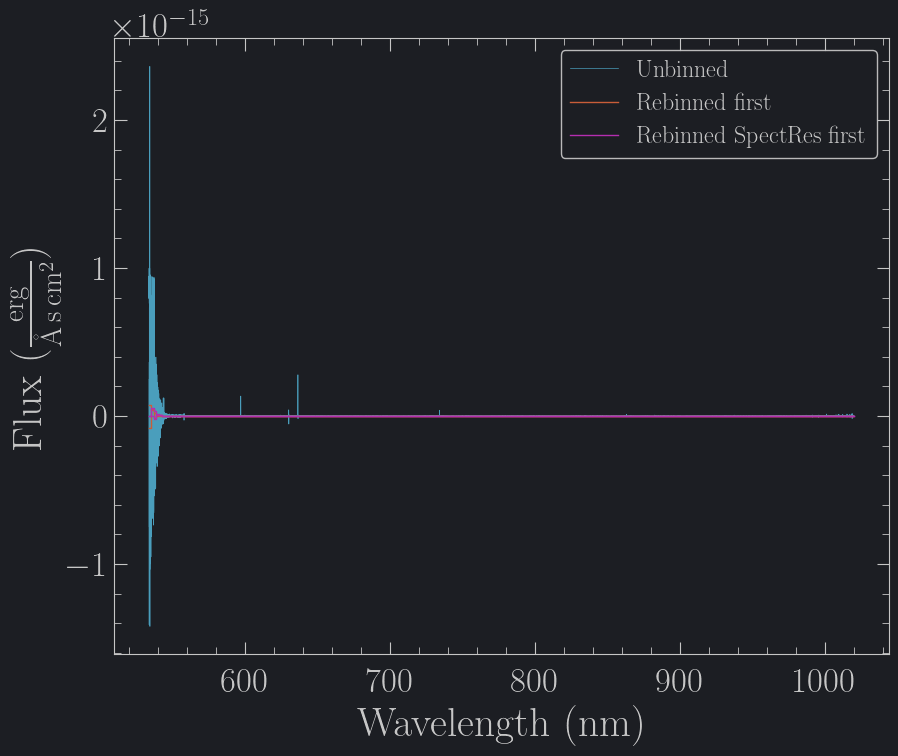

In [117]:
fig, ax = plt.subplots(figsize=(10,8))

ind_spat = 81

# Unbinned
art, = ax.plot(wvlg, flux[ind_spat], drawstyle='steps-mid', lw=0.5, label='Unbinned')
ax.plot(wvlg, unc[ind_spat], drawstyle='steps-mid', lw=1, color=art.get_color())

ind_spat_rebin = spat_rebin.searchsorted(spat[ind_spat])
# Rebinned 2D before extracting 1D
art, = ax.plot(wvlg_rebin, flux_rebin[ind_spat_rebin], drawstyle='steps-mid', lw=1, label="Rebinned first")
ax.plot(wvlg_rebin, unc_rebin[ind_spat_rebin], drawstyle='steps-mid', lw=1, color=art.get_color())

ind_spat_rebin_sp = spat_rebin_sp.searchsorted(spat[ind_spat])
# Rebinned 2D before extracting 1D
art, = ax.plot(wvlg_rebin_sp, flux_rebin_sp[ind_spat_rebin_sp], drawstyle='steps-mid', lw=1, label="Rebinned SpectRes first")
ax.plot(wvlg_rebin_sp, unc_rebin_sp[ind_spat_rebin_sp], drawstyle='steps-mid', lw=1, color=art.get_color())

ax.legend()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(f"Flux ({flux.unit:latex})")

plt.show()
